#  CS 247 : Advanced Data Mining Learning
## Homework 5 - Solution

### Due: 11:59 pm 02/23

##### Please read the Homework Guidance carefully and make sure you fulfill all the requirements.



## Problem 1: Spectral Clustering (50 pts)



In this problem, you are going to prove a property of the unormalized graph Laplacian matrix. Then, you are going to implement the spectral clustering and apply it on the Karate Club dataset.


### Part 1: Property of Unnormalized Graph Laplacian (20 pts)

Given a symmetric normalized graph Laplacian matrix $L_{sym}=D^{-1/2}(D-W)D^{1/2}$, prove that for every vector $f \in R^n$, we have:

$$
f^T L_{sym} f = \frac{1}{2}\sum_{ij} w_{ij}(\frac{f_i}{\sqrt{d_i}} - \frac{f_j}{\sqrt{d_j}}) ^ 2
$$


#### Write Your answer here:
![pic](https://drive.google.com/uc?export=view&id=1Y0nKO5-l4H3YSrTsFIM-ANM0EYMyHszy)
![pic](https://drive.google.com/uc?export=view&id=1LZJgZl8LCugIwWQdyRCnc0dS1gnQd3wo)
![pic](https://drive.google.com/uc?export=view&id=1YmKZDJ4dp74sSTYnKdStRFLRoGBaEGEv)
![pic](https://drive.google.com/uc?export=view&id=1f55vbPHHdtt6v7RgOkv6K-jcOSR9IxxZ)

### Part 2: Implement Spectral Clustering (30pts = 15 + 15)

In this part, you are going to implement the spectral clustering model, and get two clusters of the Karate club graph, then visialize them. You are allowed to use the sklearn implementation of Kmeans.

Hint:
1. Please refer to the official documentation if you want to get familiar with the networkx library: https://networkx.org/documentation/stable/tutorial.html
2. You may find this link helpful if you want to know more about the Karate Club dataset: https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.generators.social.karate_club_graph.html

In [15]:
# import neccessary libraries

import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
from scipy.linalg import sqrtm 
from numpy import linalg as LA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


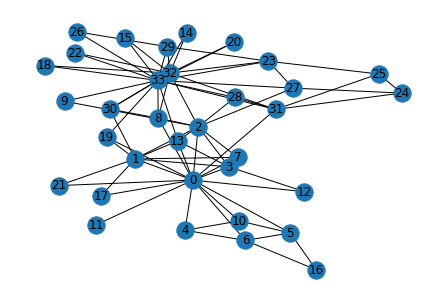

In [16]:
# load and preprocess the Karate Club Graph

G = nx.karate_club_graph()
nx.draw(G, with_labels=True, pos=nx.spring_layout(G))

A = nx.adj_matrix(G)
A = A.todense()

In [17]:
def laplacian(A):
    """
        TODO: 
            Compute: L = I-D^{-1/2} A D{-1/2}
    """
    A = np.asarray(A)
    deg = np.sum(A,1) # degree array
    degr = np.power(deg,-1/2) # root degree
    Dr = np.diag(degr) # get diagnol matrix
    L = np.eye(A.shape[0]) -  Dr@A@Dr # get L
    return L


      
    


In [18]:
def spectral_clustering(adjacency, n_clusters):
    k_means = KMeans(n_clusters=n_clusters, random_state=43) # do not change the random_state
    """
        TODO: 
            Spectral Clustering method, please return the labels.
            You can follow these steps:
                (1) Calculate the lapalacian matrix of the adjacency matrix.
                (2) Get the eigen vector of this laplacian matrix.
                (3) Get the cluster label using kmeans.     
    """
    L = laplacian(A)
    eigs,vecs = LA.linalg.eig(L)
    idx = eigs.argsort() # sort eigen vectors and values 
    eigs = eigs[idx]
    vecs = vecs[:,idx]
   
    vecs_k = vecs[:,:n_clusters] # take first k vectors

    k_means.fit(vecs_k)
    labels = k_means.labels_

    
    return labels
# use the spectral clustering method on Karate Club Graph
labels = spectral_clustering(A, 2)
print(labels) # Please keep this output in your submission


[1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


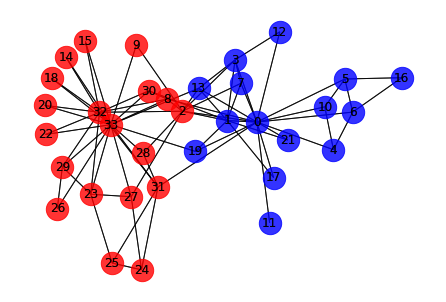

In [19]:
# visualize the results

r_nodes = []
b_nodes = []
for i, j in enumerate(labels):
    if j == 0:
        r_nodes += [i]
    else:
        b_nodes += [i]

pos = nx.spring_layout(G)
nx.draw(G,pos, with_labels=True,
                       nodelist=r_nodes,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw(G,pos, with_labels=True,
                       nodelist=b_nodes,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

## Problem 2: Node Embedding - LINE (50 pts = 30 + 20)


In this problem, you are going to implement the __First-order LINE__ (finish contrastive loss, negative sampling and training pipleline). Get embedding of karate graph, then visualize your results.

Hint: Please refer to slide 09 - Graph and Network: Graph Embedding, page 8-12 for the details of the LINE model.

In [20]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange 
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sb
import networkx as nx
import numpy as np
from scipy.linalg import sqrtm 
from numpy import linalg as LA

In [21]:
# load dataset and set parameters

G = nx.karate_club_graph()
edges  = np.array(list(G.edges))
degree = dict(G.degree)
true_labels = np.zeros(len(G.nodes))
for i in range(len(true_labels)):
    if G.nodes[i]['club']=='Officer':
        true_labels[i]=1

n_epochs = 100
neg_size = 5
batchrange = 3

In [22]:
class Line(nn.Module):
    def __init__(self, size, embed_dim=128):
        super(Line, self).__init__()

        self.embed_dim = embed_dim
        self.nodes_embeddings = nn.Embedding(size, embed_dim)
        self.sig = nn.Sigmoid()

        # Initialization
        self.nodes_embeddings.weight.data = self.nodes_embeddings.weight.data.uniform_(-.5, .5) / embed_dim

    def loss(self, v_i, v_j, negsamples):
        
        '''
            TODO: 
                implement contrastive loss here
        '''


     
        target_embs = self.nodes_embeddings(v_i) # target embeddings 

        context_pos_embs = self.nodes_embeddings(v_j) #positive context embeddings
        context_neg_embs = self.nodes_embeddings(negsamples.flatten()) #negative context embeddings
      
        target_embs1 = target_embs.repeat_interleave(negsamples.shape[1],dim=0) #target repeat for computing loss with negative context
      
        similarity_pos = torch.log(self.sig(torch.sum(context_pos_embs*target_embs,1))) # computing similarity with positive context
        similarity_neg = torch.log(self.sig((-1*torch.sum(context_neg_embs*target_embs1,1)))) # computing similarity with negative context

        final = -((torch.sum(similarity_pos) + torch.sum(similarity_neg))/len(v_i)) # computing loss
        return final          
        
    



In [37]:
#     generating batches of data.

def makeData(samplededges, negsamplesize, degree):
    sampledNodes = set()
    nodesProb = []
    sumofDegree = 0
    for e in samplededges:
        sampledNodes.add(e[0])
        sampledNodes.add(e[1])
    sampledNodes = list(sampledNodes)
    nodesProb = [pow(degree[v],3/4) for v in sampledNodes]
    sumofDegree = sum(nodesProb)
    nodesProb[:] = [x/sumofDegree for x in nodesProb]

    for e in samplededges:
        sourcenode, targetnode = e[0], e[1]
        negnodes = []
        negsamples = 0
        while negsamples < negsamplesize:
            '''
                TODO: 
                    Randomly sampled negative nodes based on degree (d^{3/4})
                    negnodes should be a list of nodes
            '''
            degree_pow = np.power(np.asarray(list(degree.values())),3/4) # get the degree array with power raised
            prob = degree_pow/np.sum(degree_pow) # get the probabilties 
       
            negnodes.append(np.random.choice(len(degree),1, p=prob)) # append the negative nodes
            negsamples += 1

            
        yield [e[0], e[1]] + negnodes

        


In [40]:
# training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
line = Line(len(G), embed_dim=100).to(device)
opt = optim.Adam(line.parameters())


for epoch in range(n_epochs):
    for b in trange(batchrange):
        opt.zero_grad()
        edge_idx = np.random.choice(len(edges), 10)
        samplededges = edges[edge_idx]
        
        batch = list(makeData(samplededges, neg_size, degree))
        batch = torch.LongTensor(batch).to(device)
        
        # based on the generated batch, train LINE via minimizing the loss.
        v_i = batch[:,0]
        v_j = batch[:,1]
        negsamples =  batch[:,2:]
        loss = line.loss(v_i, v_j, negsamples)
        loss.backward()
        opt.step()


100%|██████████| 3/3 [00:00<00:00, 85.53it/s]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


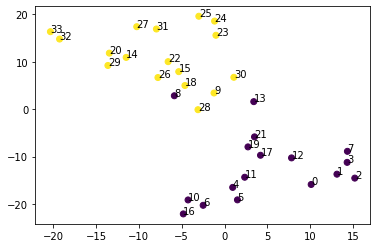

In [42]:
# TSNE visualization, with node id on

emb  = line.nodes_embeddings.weight.data.cpu().numpy()
tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10, random_state=1).fit_transform(emb)

plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=true_labels)
for i in range(len(tsne_emb)):
    plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
plt.show()



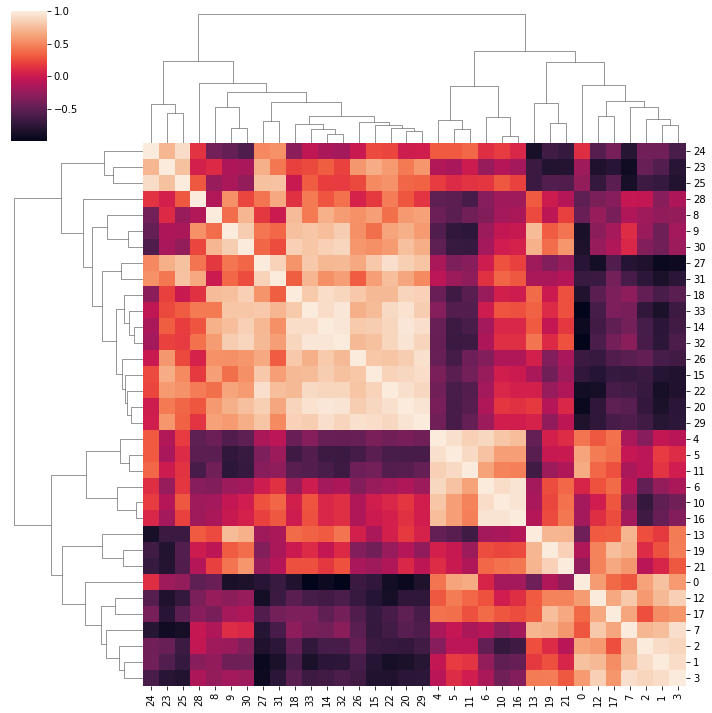

In [43]:
# heatmap visualization, check cosine similarities between all pair of nodes
res = cosine_similarity(emb) 

sb.clustermap(res)
plt.show()

## Bonus Problem: Normalized Cut (10pts)

### Background
Consider the problem of partitioning a graph $G = (V,E)$ into two subgraphs with similar sizes. Let $A ⊆ V$ and $B ⊆ V$ denote the disjoint node sets of the two clusters. Let $cut(A, B)$ denote the total number of edges or total weight of edges that separate the two clusters, i.e., $cut(A,B) =$ $\Sigma_{i∈A,j∈B}$ $w_{ij}$, where $w_{ij}$ denotes the weight associated with edge between i and j. Let $d_X$ = $\Sigma_{i∈X} d_i$ be the total degree of nodes in cluster $X$, the normalized cut between two clusters is defined as:

$Ncut(A,B)=\frac{cut(A,B)}{d_A}+\frac{cut(B,A)}{d_B}$

Let $f$ be the cluster indicator vector, where:
$f_i=\begin{cases} 
\sqrt{\frac{d_B}{d_A}} & if\ i\in A\\
-\sqrt{\frac{d_A}{d_B}} & if\ i\in B
\end{cases}$

Let $D$ be the diagonal matrix with $D_{ii}$ = $\Sigma_j w_{ij}$, and 0 elsewhere.

### Part 1 (5 pts)

Prove that for an arbitrary cluster indicator vector $f$, minimizing $f^TLf$ is equivalent to minimizing $Ncut(A,B)$, where $A$, $B$ are clusters indicated by $f$.

#### Hint:
Prove $f^TLf=kNcut(A,B)$, where $k$ is a constant.

#### Write Your Answer Here
![pic](https://drive.google.com/uc?export=view&id=1P_IUCpjo0t8qX57sRU2k36nO-PFvJCqN)
![pic](https://drive.google.com/uc?export=view&id=1uqbd7EZ2docZ54ugWdS8etoOp3sLFnwD)
![pic](https://drive.google.com/uc?export=view&id=1wUeV6EXojbWw96pyhx9Dn2fkPXeWAcBI)
![pic](https://drive.google.com/uc?export=view&id=1Aax9P8BXbSuqhQSMZYRZGRIvy8T-uIfe)


### Part 2 (5 pts)

To find the partition that minimizes the normalized cut between $A$, $B$, we  want to find $f$ that minimizes $Ncut(A,B)$. A typical way to do that is to __relax $f$ to a real vector__, and the problem can be formulated as

\begin{align}
\min_{f\in \mathcal{R}^{|V|}} \quad f^TLf, \quad s.t.\quad (Df)^T\mathbf{1} = 0, \quad f^TDf = d_V \quad (1)
\end{align}

where $d_V$ is the total degree of all the nodes.



__Prove the solution of $f$ of the relaxed problem shown in (1) is the second eigenvector of $L_{rw}$.__

Hint: 

Let $g = D^{1/2}f$, substitute f with g in the aforementioned objective function and constraints. Prove the solution of g is the second eigenvector of $L_{sym}$. See the lecture slides to see the relationship between the eigenvectors of $L_{rw}$ and $L_{sym}$.


#### Write your answer here:
![pic](https://drive.google.com/uc?export=view&id=18Fa5IXX3gdt6Q9NjwsvhNaYfwUKTyvJD)
![pic](https://drive.google.com/uc?export=view&id=1rsf_fHGHVk6TkvZ92P6GTrbTymig2dy4)
![pic](https://drive.google.com/uc?export=view&id=1eeWUYmh6Aw9Xil6VMUAIchz94JrPG1hy)
![pic](https://drive.google.com/uc?export=view&id=1sEPTMJIImG1HPtLI1tU-1PAWeSzk5by_)
![pic](https://drive.google.com/uc?export=view&id=1TVYwBgc9sBmm8hU3Hkroqvo8MyKlUVdW)